In [1]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 

client = bnb_client()

def get_binance_px(symbol,freq,start_ts = '2019-01-01'):
    data = client.get_historical_klines(symbol,freq,start_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 

univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

freq = '1h'
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()

In [3]:
# standard rank-demean-normalized portfolio
hor = 1
port = (-1.0*ret.rolling(hor,min_periods=1).mean()).rank(1)
port = port.subtract(port.mean(1),0)
port = port.divide(port.abs().sum(1),0)
port

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,-0.333333,0.000000,0.166667,0.333333,-0.166667,NaN,NaN
2019-01-01 02:00:00,-0.333333,0.000000,-0.166667,0.333333,0.166667,NaN,NaN
2019-01-01 03:00:00,0.166667,0.000000,-0.333333,0.333333,-0.166667,NaN,NaN
2019-01-01 04:00:00,0.333333,-0.166667,0.000000,-0.333333,0.166667,NaN,NaN
...,...,...,...,...,...,...,...
2022-01-05 20:00:00,0.000000,0.166667,-0.250000,-0.083333,-0.166667,0.250000,0.083333
2022-01-05 21:00:00,-0.083333,0.166667,-0.166667,0.000000,-0.250000,0.250000,0.083333
2022-01-05 22:00:00,-0.166667,-0.083333,0.000000,0.166667,0.250000,-0.250000,0.083333
2022-01-05 23:00:00,0.083333,0.000000,0.250000,0.166667,-0.250000,-0.083333,-0.166667


In [4]:
# compute turnover
to = (port.fillna(0) - port.shift().fillna(0)).abs().sum(1)
to

2019-01-01 00:00:00    0.000000
2019-01-01 01:00:00    1.000000
2019-01-01 02:00:00    0.666667
2019-01-01 03:00:00    1.000000
2019-01-01 04:00:00    1.666667
                         ...   
2022-01-05 20:00:00    1.166667
2022-01-05 21:00:00    0.333333
2022-01-05 22:00:00    1.666667
2022-01-05 23:00:00    1.500000
2022-01-06 00:00:00    1.000000
Freq: H, Length: 26425, dtype: float64

<AxesSubplot:>

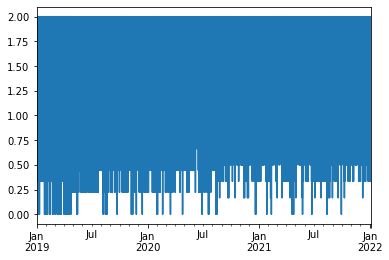

In [5]:
# plot turnover
to.plot()

In [6]:
# average turnover
to.mean()

1.360245979186299

In [7]:
# gross of tcost returns
gross_ret = (port.shift()*ret).sum(1)

In [8]:
gross_ret.mean() / gross_ret.std() * np.sqrt(24*365)

7.098388804535415

In [9]:
# net of tcost returns
tcost_bps = 20 # (comissions + slip)
net_ret = gross_ret.subtract(to*tcost_bps*1e-4,fill_value=0)

In [10]:
net_ret.mean() / net_ret.std() * np.sqrt(24*365)

-48.74027172503039